# **Analysis tutorial**

In this tutorial you can learn how to apply some well known statistical tests to your dataframe. This tests are implemented as part of the functionality of PyOskar API using the transformers Spark model. These kind of functions depend directly from an _Oskar_ object, and they will return a whole dataframe with the due transformation applied.
> <span style="color:#ff6600"> **PySpark default API is integrated with PyOskar so it is possible to manage data with PySpark functions, in case we want to select specific fields, visualize the dataframe, filter the output, etc.** </span>

This tutorial will show the next analysis:
 
 - **Poblational analysis**
- Hardy-Weinberg
- Inbereding Coefficient
- Identity By State
- Identity By Descent
<br>
<br>
 - **Dataframe analysis**
- Mendelian Error
- Compound Heterozygote
- PCA
<br>
<br>
 - **GWAS**
- Chi-squared test
- Fisher test

Let's see how it works:

First, we need to import the PyOskar and PySpark modules. Second, we need to create an instance of the _Oskar_ object, from which depends a big part of the functionality. Finally, we can load our data in a DataFrame _df_ and we are ready to start playing.

In [17]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("./data/platinum_chr22.small.parquet")

This is how our testing dataframe looks like. For this tutorial we are using a small dataset from Illumina Platinum Genomes with 1,000 random variants from chromosome 22:

In [3]:
print("Print first 20 variants:")
df.show()

Print first 20 variants:
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|             id|names|chromosome|   start|     end|reference|alternate|strand|  sv|length| type|hgvs|             studies|          annotation|
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|22:16054454:C:T|   []|        22|16054454|16054454|        C|        T|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16054454, 16...|
|22:16065809:T:C|   []|        22|16065809|16065809|        T|        C|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16065809, 16...|
|22:16077310:T:A|   []|        22|16077310|16077310|        T|        A|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16077310, 16...|
|22:16080499:A:G|   []|        22|16080499|16080499|        A|        G|     +|null|     1|  SNV|  []|[[h

NOTE: With _df.printSchema()_ command you can check the dataset hierarchy and all its fields.

In [5]:
print("Total number of variants:")
df.count()

Total number of variants:


1000

 We will give a few examples of simple queries that could be of interest for the user:

# Poblational analysis

## Hardy Weinberg
This transformer calculates the Hardy Weinberg Equilibrium based fisher test by using the poblational data stored in the dataframe.
<br>
Usage:
```python
hardyWeinberg(df[DataFrame], studyId[str]=None)
```

In [6]:
oskar.hardyWeinberg(df, "hgvauser@platinum:illumina_platinum").select("id", "HWE").show(10)

+---------------+--------------------+
|             id|                 HWE|
+---------------+--------------------+
|22:16054454:C:T|                 1.0|
|22:16065809:T:C|                 1.0|
|22:16077310:T:A|  0.9254727474972191|
|22:16080499:A:G|                 1.0|
|22:16084621:T:C|                 1.0|
|22:16091610:G:T|                 1.0|
|22:16096040:G:A|  0.4746014089729329|
|22:16099957:C:T|0.016007636455477054|
|22:16100462:A:G|0.001011008618240...|
|22:16105660:G:A|  0.3037449017426771|
+---------------+--------------------+
only showing top 10 rows



In [8]:
oskar.hardyWeinberg(df, "hgvauser@platinum:illumina_platinum").select("id", "HWE").filter("HWE < 0.005").show(10, truncate = False)

+---------------+---------------------+
|id             |HWE                  |
+---------------+---------------------+
|22:16100462:A:G|0.0010110086182406558|
|22:16147398:G:A|0.0010112245929821014|
|22:16202382:C:T|0.0010110086182406558|
|22:16409256:C:A|0.0010110086182406558|
|22:16409275:T:C|0.0010110086182406558|
|22:16463338:T:C|4.51387209620996E-5  |
|22:16847903:T:A|1.1233429091562846E-4|
|22:16850925:C:T|1.1233429091562846E-4|
|22:16853987:T:C|1.1233429091562846E-4|
|22:16854418:G:A|1.1233429091562846E-4|
+---------------+---------------------+
only showing top 10 rows



## Inbreeding coefficient
This transformer calculates the Hardy Weinberg Equilibrium based Coefficient Of Inbreeding by using the poblational data stored in the dataframe. This method needs a previous transformation that generates new stats data. The use of the _stats_ function is fully explained in the _stats_ tutorial.
<br>
Usage:
```python
inbreedingCoefficient(df[DataFrame], missingGenotypesAsHomRef[bool]=None, includeMultiAllelicGenotypes[bool]=None, mafThreshold[float]=None)
```

In [13]:
df2 = oskar.stats(df, studyId = "hgvauser@platinum:illumina_platinum")
oskar.inbreedingCoefficient(df2).show(10)

+--------+-------------------+-----------+------------------+--------------+
|SampleId|                  F|ObservedHom|       ExpectedHom|GenotypesCount|
+--------+-------------------+-----------+------------------+--------------+
| NA12877| -0.846697214447447|         67|211.42520779371262|           382|
| NA12878| -0.876318449583936|         65| 221.4588798880577|           400|
| NA12879|-0.8380378596211293|         69|219.00477409362793|           398|
| NA12880|  -0.85398002158741|         69| 224.6895123720169|           407|
| NA12881|-0.8671775492595221|         65|227.55130487680435|           415|
| NA12882|-0.7976480874076881|         74|205.34040838479996|           370|
| NA12883|-0.8783264633513055|         64|211.76513189077377|           380|
| NA12884|-0.8136899034620303|         72| 204.7967967391014|           368|
| NA12885|-0.8019791912247425|         78|227.53835332393646|           414|
| NA12886|-0.8364469410381973|         70|222.12706524133682|           404|

In [19]:
df2 = oskar.stats(df, studyId = "hgvauser@platinum:illumina_platinum", missingAsReference = True)
oskar.inbreedingCoefficient(df2).filter("F > -1").show()

+--------+---+-----------+-----------+--------------+
|SampleId|  F|ObservedHom|ExpectedHom|GenotypesCount|
+--------+---+-----------+-----------+--------------+
+--------+---+-----------+-----------+--------------+



_* This null result evidences that there are a lot more observed heterozygous variants than expected, so Inbreeding cases are unlikely for this population's ancestry._

## Identity by state
An interesting test we may want to execute is IBS, wich could give us important information about genotype similarity.
<br>
Usage:
```python
ibd(df[DataFrame], samples[list<str>]=None, skipMultiAllelic[bool]=None, skipReference[bool]=None, numPairs[int]=None)
```

In [36]:
# numPairs qué hace? porque el resultado es el mismo aunq lo modifiques
oskar.ibs(df).show(10)

+------------------+------------------+------------+--------+----+
|        samplePair|          distance|      counts|variants|skip|
+------------------+------------------+------------+--------+----+
|[NA12877, NA12878]|0.8928571428571429|[0, 57, 209]|     266| 734|
|[NA12877, NA12879]|0.9155629139072847|[0, 51, 251]|     302| 698|
|[NA12877, NA12880]|0.9028662420382165|[0, 61, 253]|     314| 686|
|[NA12877, NA12881]|0.9116719242902208|[0, 56, 261]|     317| 683|
|[NA12877, NA12882]|0.8934707903780069|[0, 62, 229]|     291| 709|
|[NA12877, NA12883]| 0.891156462585034|[0, 64, 230]|     294| 706|
|[NA12877, NA12884]|0.8904109589041096|[0, 64, 228]|     292| 708|
|[NA12877, NA12885]|0.9115755627009646|[0, 55, 256]|     311| 689|
|[NA12877, NA12886]| 0.909967845659164|[0, 56, 255]|     311| 689|
|[NA12877, NA12887]|0.9096989966555183|[0, 54, 245]|     299| 701|
+------------------+------------------+------------+--------+----+
only showing top 10 rows



In case we don't specify any samples it will run the whole dataframe samples, but we may want to check similarity between particular individuals:

In [37]:
oskar.ibs(df, samples = ["NA12877", "NA12878", "NA12879", "NA12880", "NA12881", "NA12882"]).show()

+------------------+------------------+------------+--------+----+
|        samplePair|          distance|      counts|variants|skip|
+------------------+------------------+------------+--------+----+
|[NA12877, NA12878]|0.8928571428571429|[0, 57, 209]|     266| 734|
|[NA12877, NA12879]|0.9155629139072847|[0, 51, 251]|     302| 698|
|[NA12877, NA12880]|0.9028662420382165|[0, 61, 253]|     314| 686|
|[NA12877, NA12881]|0.9116719242902208|[0, 56, 261]|     317| 683|
|[NA12877, NA12882]|0.8934707903780069|[0, 62, 229]|     291| 709|
|[NA12878, NA12879]|0.8857615894039735|[0, 69, 233]|     302| 698|
|[NA12878, NA12880]|0.8888888888888888|[0, 72, 252]|     324| 676|
|[NA12878, NA12881]|0.8931888544891641|[0, 69, 254]|     323| 677|
|[NA12878, NA12882]|0.9064516129032258|[0, 58, 252]|     310| 690|
|[NA12879, NA12880]|0.9016666666666666|[0, 59, 241]|     300| 700|
|[NA12879, NA12881]|0.9033333333333333|[0, 58, 242]|     300| 700|
|[NA12879, NA12882]|0.9325259515570934|[0, 39, 250]|     289| 

## Identity by descent
Some other interesting test we may want to execute is IBD, wich could give us important information about common ancestors.
<br>
Usage:
```python
ibd(df[DataFrame], samples[list<str>]=None, skipMultiAllelic[bool]=None, skipReference[bool]=None, numPairs[int]=None)
```

In [35]:
# KE LE PASA A LAS COLUMNAS DEL FINAL?
oskar.ibd(df).show(10)

+------------------+------------------+------------+--------+----+---------------+------+
|        samplePair|          distance|      counts|variants|skip|            IBD|PI_HAT|
+------------------+------------------+------------+--------+----+---------------+------+
|[NA12877, NA12878]|0.8928571428571429|[0, 57, 209]|     266| 734|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12879]|0.9155629139072847|[0, 51, 251]|     302| 698|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12880]|0.9028662420382165|[0, 61, 253]|     314| 686|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12881]|0.9116719242902208|[0, 56, 261]|     317| 683|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12882]|0.8934707903780069|[0, 62, 229]|     291| 709|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12883]| 0.891156462585034|[0, 64, 230]|     294| 706|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12884]|0.8904109589041096|[0, 64, 228]|     292| 708|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12885]|0.9115755627009646|[0, 55, 256]|     311| 689|[NaN, NaN, NaN]|   NaN|
|[NA12877,

In case we don't specify any samples it will run the whole dataframe samples, but we may want to check similarity between particular individuals:

In [34]:
# Este resultado está puteao, las samples rayan al método si no están 77 y 78.
oskar.ibd(df, samples = ["NA12880", "NA12881", "NA12882", "NA12883", "NA12884"]).show(10)

+------------------+------------------+------------+--------+----+---------------+------+
|        samplePair|          distance|      counts|variants|skip|            IBD|PI_HAT|
+------------------+------------------+------------+--------+----+---------------+------+
|[NA12883, NA12884]|0.9384858044164038|[0, 39, 278]|     317| 683|[NaN, NaN, NaN]|   NaN|
+------------------+------------------+------------+--------+----+---------------+------+



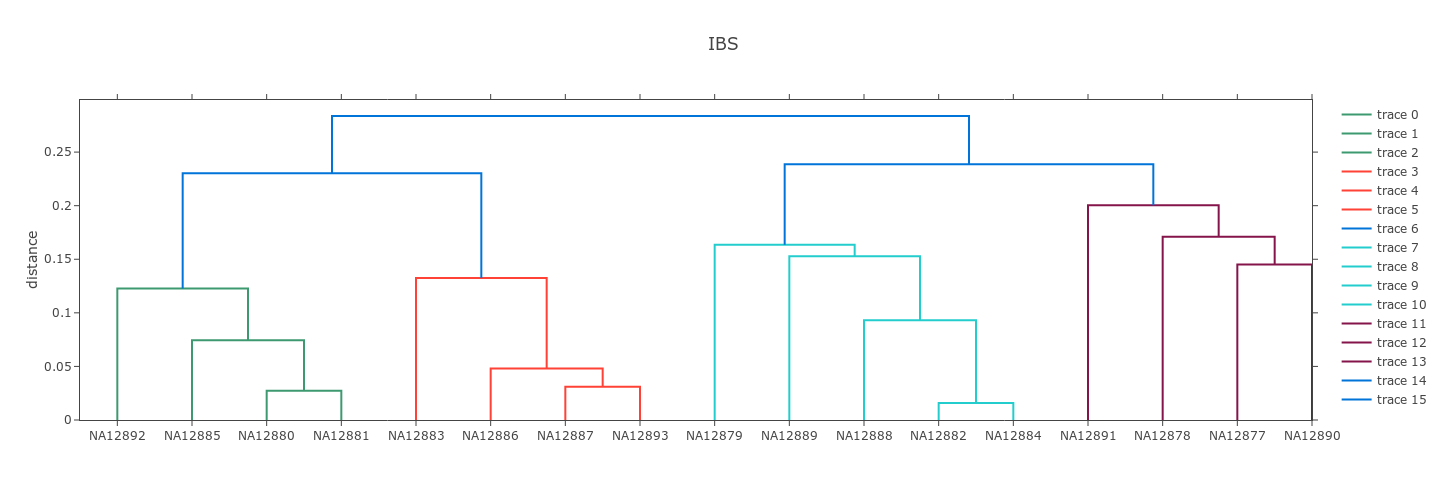

In [39]:
import numpy as np
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.offline import get_plotlyjs, init_notebook_mode

init_notebook_mode(connected = True)

OskarIBS = oskar.ibs(df).toPandas()
samples_list = []
samples_dict = {}
num_of_values = len(OskarIBS)
for i in range(len(OskarIBS)):
    sample = OskarIBS["samplePair"][i][0]
    if not sample in samples_dict:
        samples_list.append(sample)
        samples_dict[sample] = []
    samples_dict[sample].append(1 - OskarIBS["distance"][i])
samples_dict[OskarIBS["samplePair"][num_of_values - 1][1]] = []
samples_list.append(OskarIBS["samplePair"][num_of_values - 1][1])

num_of_samples = len(samples_dict)
X = np.zeros((num_of_samples,num_of_samples))

for j in range(0, num_of_samples - 1):    
    for i in range(j + 1, num_of_samples):
        X[i,j] = samples_dict[samples_list[j]][i - 1 - j]
        X[j,i] = samples_dict[samples_list[j]][i - 1 - j]
        
fig = ff.create_dendrogram(X, labels = samples_list, color_threshold = 0.21)
yaxis = {"title": "distance"}
fig['layout'].update({'width':1440, 'height':500, 'showlegend':True, "title":"IBS", "yaxis":yaxis})
py.iplot(fig, filename = 'dendrogram')

<br>

# Dataframe analysis

## Mendelian error
This transformer looks for variants which can't have been inherited by the specified parent samples.
<br>
Usage:
```python
mendel(df[DataFrame], father[str], mother[str], child[str], studyId[str]=None)
```

In [24]:
oskar.mendel(df, "NA12877", "NA12878", "NA12879").select("id", "mendelianError").show(10)

+---------------+--------------+
|             id|mendelianError|
+---------------+--------------+
|22:16054454:C:T|             0|
|22:16065809:T:C|             0|
|22:16077310:T:A|             0|
|22:16080499:A:G|             0|
|22:16084621:T:C|             0|
|22:16091610:G:T|             0|
|22:16096040:G:A|             0|
|22:16099957:C:T|             0|
|22:16100462:A:G|             0|
|22:16105660:G:A|             0|
+---------------+--------------+
only showing top 10 rows



In [15]:
oskar.mendel(df, "NA12877", "NA12878", "NA12879").select("id", "mendelianError").filter(col("mendelianError") != "0").show()

+------------------+--------------+
|                id|mendelianError|
+------------------+--------------+
|22:19748211:CCCC:-|             1|
+------------------+--------------+



## Compound heterozygote
Other query in which we may have interest is looking for the genes that contain more than one different recessive mutations.
<br>
Usage:
```python
compoundHeterozygote(df[DataFrame], father[str], mother[str], child[str], studyId[str]=None, missingGenotypeAsReference[bool]=None)
```

In [3]:
oskar.compoundHeterozygote(df, "NA12877", "NA12878", "NA12879", missingGenotypeAsReference = True).show(10)

+------------+-----------+---------------+
|        gene|numVariants|        variant|
+------------+-----------+---------------+
|       MED15|          2|22:20875777:G:A|
|       MED15|          2|22:20913878:G:A|
|        DRG1|          2|22:31860687:T:A|
|        DRG1|          2|22:31806674:A:G|
|        SYN3|          3| 22:32912206:T:|
|        SYN3|          3|22:33174500:G:A|
|        SYN3|          3|22:33224439:C:T|
|      NBEAP3|          2|22:16105660:G:A|
|      NBEAP3|          2|22:16112391:G:A|
|RP1-90G24.10|          3|22:32667243:T:C|
+------------+-----------+---------------+
only showing top 10 rows



In [10]:
oskar.compoundHeterozygote(df, "NA12877", "NA12878", "NA12879", missingGenotypeAsReference = True).filter("gene == 'CTA-929C8.8'").show()

+-----------+-----------+---------------+
|       gene|numVariants|        variant|
+-----------+-----------+---------------+
|CTA-929C8.8|          3|22:27725153:A:G|
|CTA-929C8.8|          3|22:27748774:C:T|
|CTA-929C8.8|          3|22:27751277:A:G|
+-----------+-----------+---------------+



# PCA
Explicar movida PCA.

In [43]:
oskar.PCA(df, "hgvauser@platinum:illumina_platinum", 2).show(10, truncate=False)

+------------------------------------------+
|PCA                                       |
+------------------------------------------+
|[-0.20042428230493375,0.27615690455035713]|
|[-1.4901406718980328,-0.1731403403832562] |
|[-1.7067883342393546,-1.2997395546743808] |
|[-0.9509573129368865,-0.4464814625928924] |
|[-1.214560926377327,-1.2688293377264777]  |
|[-0.7060150021201016,-0.8560098849203093] |
|[-2.1679805827459653,-0.31212551485992]   |
|[-4.759447222296315,-0.136049081685385]   |
|[-3.853421980571116,0.020472983740877873] |
|[-2.445546107629358,-0.8412610558880798]  |
+------------------------------------------+
only showing top 10 rows



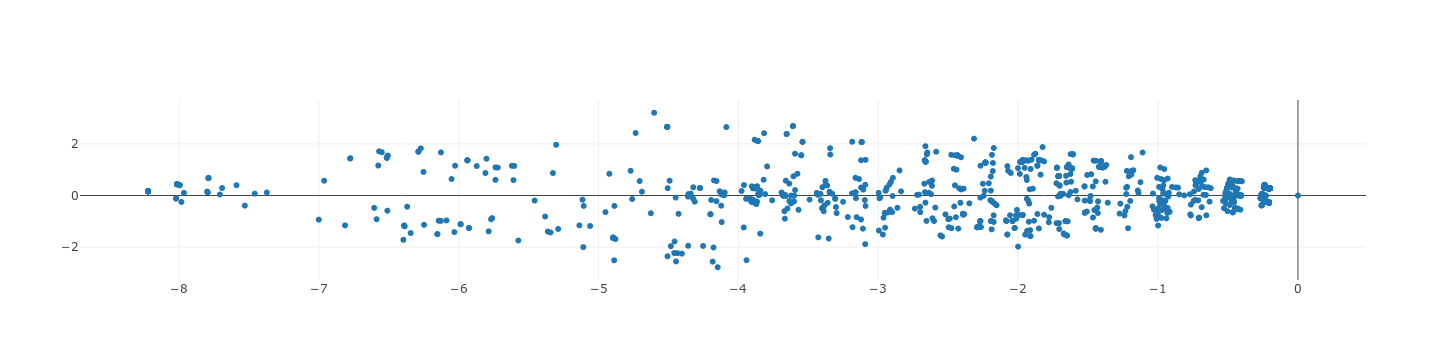

In [44]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import get_plotlyjs, init_notebook_mode

PCAdf = oskar.PCA(df, "hgvauser@platinum:illumina_platinum", 2).toPandas()

init_notebook_mode(connected=True)

X = []
for i in PCAdf["PCA"]:
    X.append(i[0])
Y = []
for i in PCAdf["PCA"]:
    Y.append(i[1])

trace = go.Scatter(
    x = X,
    y = Y,
    mode = 'markers'
)

data = [trace]
    
py.iplot(data)

<br>

# GWAS

These GWAS transformers take the poblational information stored in the DataFrame to calculate the corresponding p-values. The user will need to specify a particular study and the phenotype he aims to analyze.

## Chi-squared
Usage:
```python
chiSquare(df[DataFrame], studyId[str], phenotype[str])
```

In [28]:
oskar.chiSquare(df, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value")).show(10)

+---------------+-------------------+
|             id|  ChiSquare p-value|
+---------------+-------------------+
|22:16054454:C:T|0.11583677431831574|
|22:16065809:T:C| 0.8162967146689325|
|22:16077310:T:A| 0.3243241555798487|
|22:16080499:A:G|0.16932729721206297|
|22:16084621:T:C|0.11808572685033702|
|22:16091610:G:T|0.24164568184122925|
|22:16096040:G:A|0.24839711482150617|
|22:16099957:C:T| 0.9283082406877704|
|22:16100462:A:G| 0.8244791006886252|
|22:16105660:G:A| 0.9612450306338958|
+---------------+-------------------+
only showing top 10 rows



## Fisher
Usage:
```python
fisher(df[DataFrame], studyId[str], phenotype[str])
```

In [30]:
oskar.fisher(df, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value")).show(10)

+---------------+-------------------+
|             id|     Fisher p-value|
+---------------+-------------------+
|22:16054454:C:T| 0.2941176470588194|
|22:16065809:T:C| 0.9999999999999629|
|22:16077310:T:A| 0.6444578943924588|
|22:16080499:A:G|0.29575642573744654|
|22:16084621:T:C| 0.2907969639468656|
|22:16091610:G:T| 0.5387700534759321|
|22:16096040:G:A|0.39512983254395534|
|22:16099957:C:T| 0.9999999999999654|
|22:16100462:A:G| 0.9999999999999866|
|22:16105660:G:A| 0.9999999999999954|
+---------------+-------------------+
only showing top 10 rows



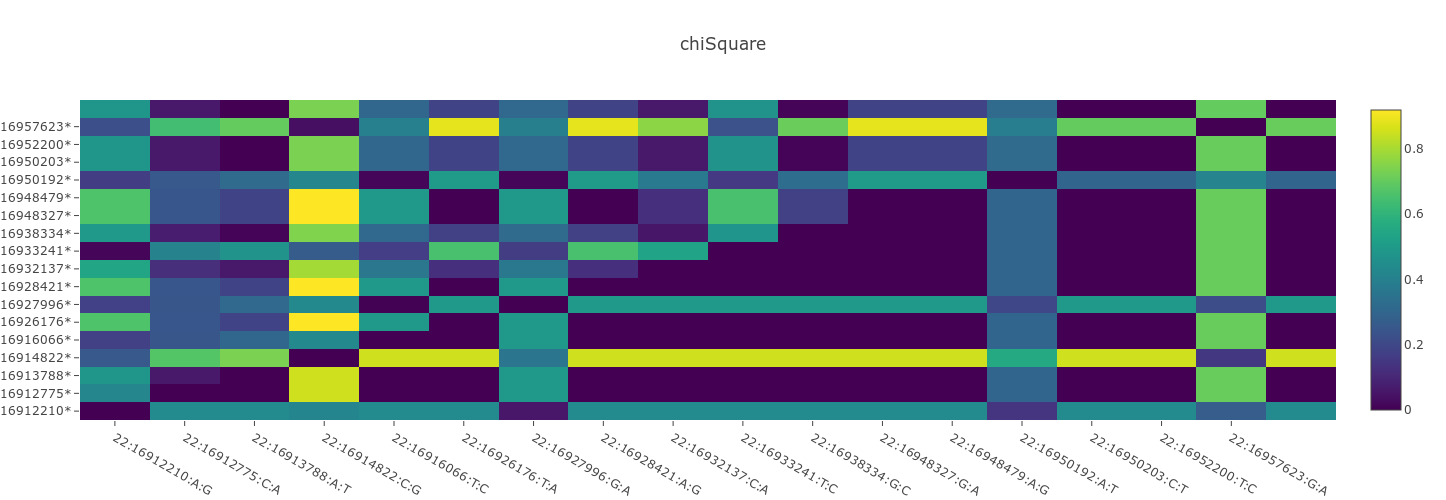

In [32]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import get_plotlyjs, init_notebook_mode

init_notebook_mode(connected = True)

SLCdf = df.filter(array_contains(genes("annotation"), "SLC9B1P4"))

pandasFisher = oskar.fisher(SLCdf, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value").alias("fisher")).toPandas()
pandasChiSquare = oskar.chiSquare(SLCdf, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value").alias("chiSquare")).toPandas()

labels = pandasFisher["id"].tolist()
labelsPosition = [i.split(':', 3)[1] + "*" for i in labels]

# dim = len(labels)
# X = np.zeros((dim, dim))
# for i in range(dim):
#     for j in range(dim):
#         X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

dim = len(labels)
X = np.zeros((dim, dim))
for i in range(dim):
    for j in range(i, dim):
        X[i, j] = np.absolute(pandasFisher["fisher"][i] - pandasFisher["fisher"][j])
for i in range(dim):
    for j in range(i, dim):
        X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

trace = go.Heatmap(x = labels, y= labelsPosition, z = X, colorscale = 'Viridis')
fig = go.Figure(data = [trace])
fig['layout'].update({'width':1440, 'height':500, 'title':'chiSquare'})
py.iplot(fig, filename = 'annotated_heatmap_color')